# **Part 2: Data Summary**

#### This second part is a report summarizing important features of the data, with the objective of detecting trends or patterns that can help us understand it better. It also includes the answer to some features that could not be explained in Part 1 and that have led to a further data cleaning.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# pip install geopandas
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/My Drive/DATA_SCIENCE/Taxi_Test/data/YellowTaxi_Mar-Jun-Nov2017.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,1,148,48,14.0,0.5,3.06,0.0,0.3,18.36,14.150000
1,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,1,79,162,10.0,0.5,2.82,0.0,0.3,14.12,10.133333
2,1,2017-03-01 00:00:00,2017-03-01 00:14:22,1,2.80,1,1,261,79,12.5,0.5,1.00,0.0,0.3,14.80,14.366667
3,1,2017-03-01 00:00:00,2017-03-01 00:19:30,1,6.00,1,1,87,142,19.5,0.5,3.50,0.0,0.3,24.30,19.500000
4,1,2017-03-01 00:00:00,2017-03-01 00:34:27,1,8.70,1,1,142,181,30.0,0.5,7.80,0.0,0.3,39.10,34.450000


In [3]:
df.shape

(18894786, 16)

The correlation heatmap shows interesting positive correlations not only for the tip amount, but also for variables such as the fare amount or the trip distance:

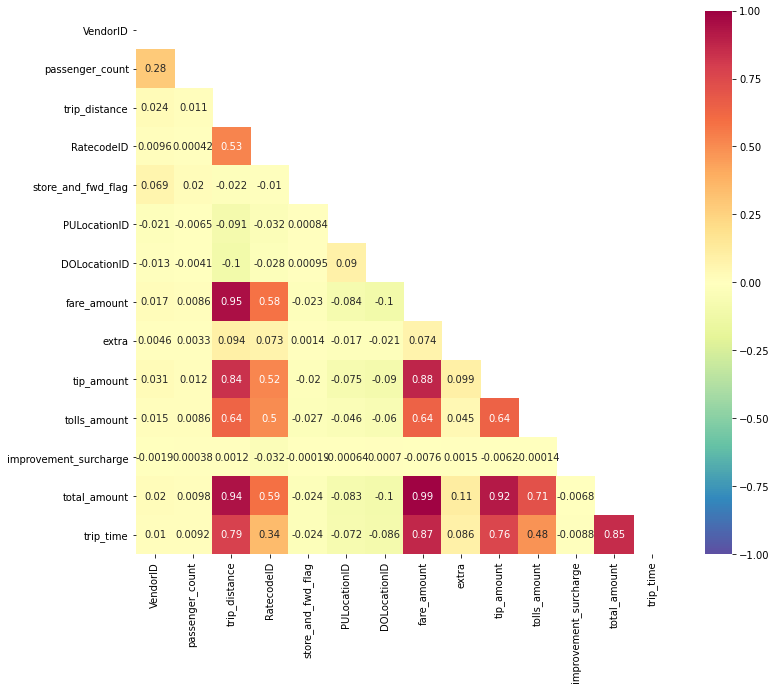

In [ ]:
plt.figure(figsize=(12,10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(),cmap='Spectral_r',mask=matrix,annot=True,cbar=True,vmin=-1,vmax=1,center=0)

We now select a random subset of the whole datatset. 1% of almost 19 million rows. With this action we intend to reduce the sample to build the model (otherwise training times would be too long and computational resources might not be enough).

In [123]:
df2 = df.sample(frac=0.01)
df2['tpep_pickup_datetime'] = pd.to_datetime(df2['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df2['tpep_dropoff_datetime'] = pd.to_datetime(df2['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
df2.shape

(188948, 16)

Create columns for week days and hours of the day:

In [124]:
df2['weekday'] = df2['tpep_pickup_datetime'].dt.weekday
df2['pickup_hour'] = df2['tpep_pickup_datetime'].dt.hour

## **Tip amount vs Other variables** (Scatter Plots)

Scatter plots of the tip amount against the rest of variables for the 3 months separately (March, June and November). It reveals a constant value in the fare amount at 52 $. Another result is that there is no clear dependency with the months.

Measuring the variables by the day of the week (colors) does not provide an additional insight neither, except for the pick-up hour. For this, we can see that the tips between midnight and early morning tend to be concentrated for Saturday and Sunday, when people come back home after going out. This will be visualized more in details afterwards.

Also, the **improvement_surcharge** values of 0 do not show a clear pattern and seem to be just erroneous data, so the column can be dropped because it is mostly a constant (0.3).

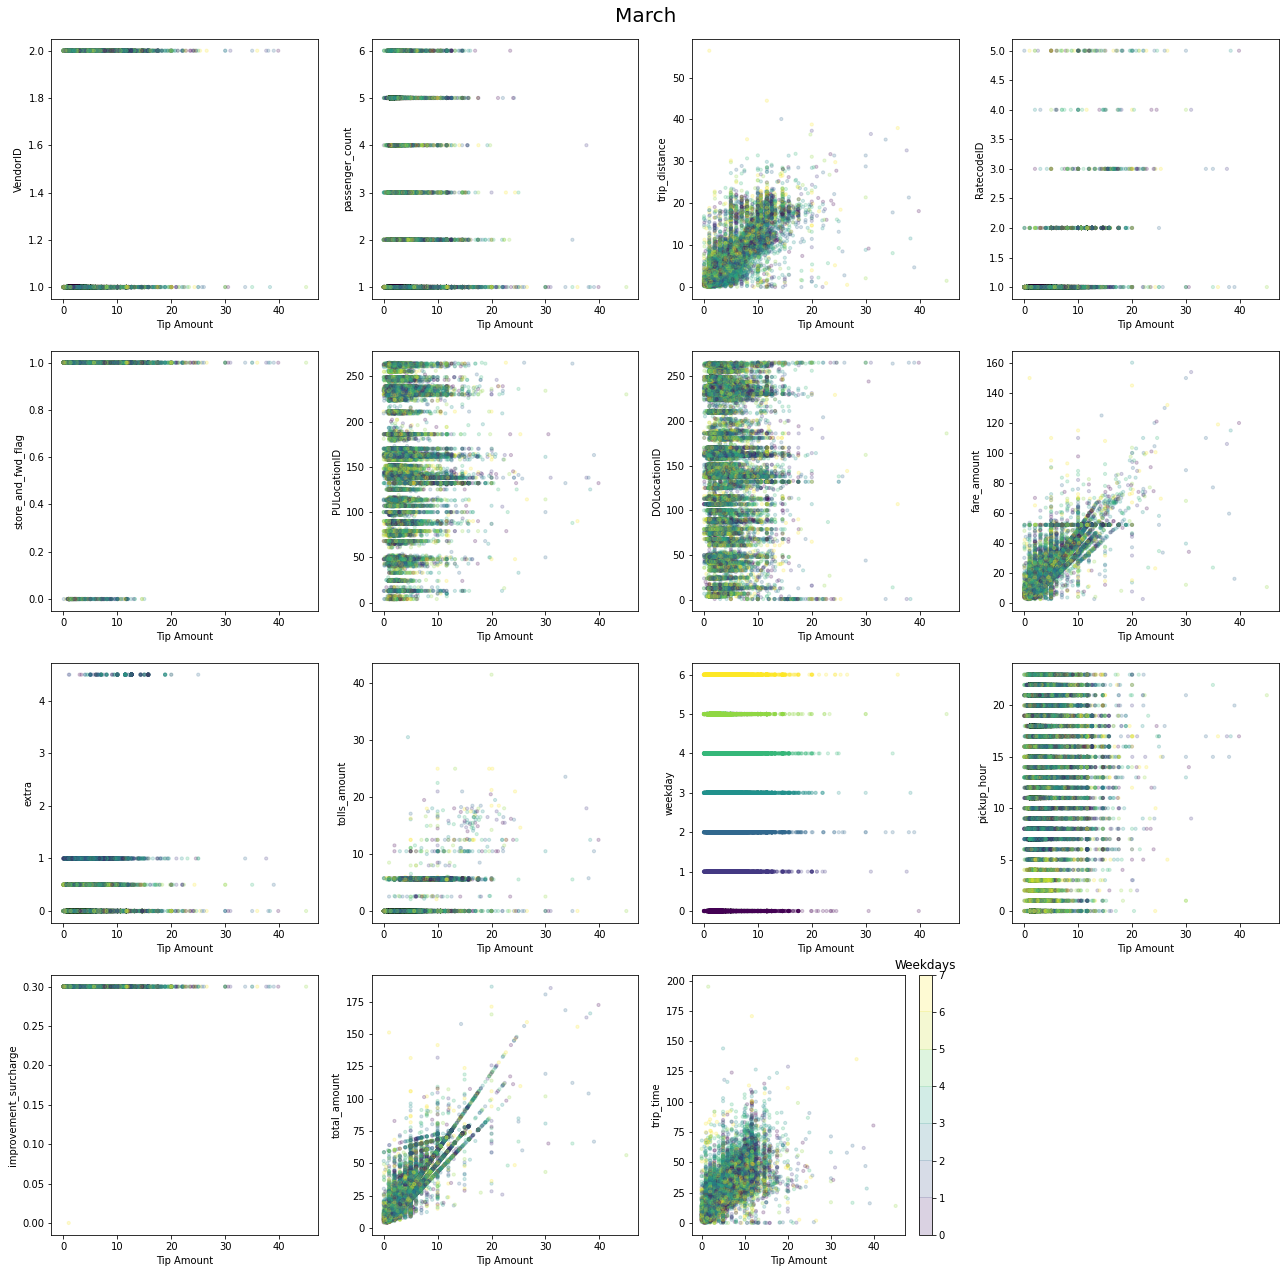

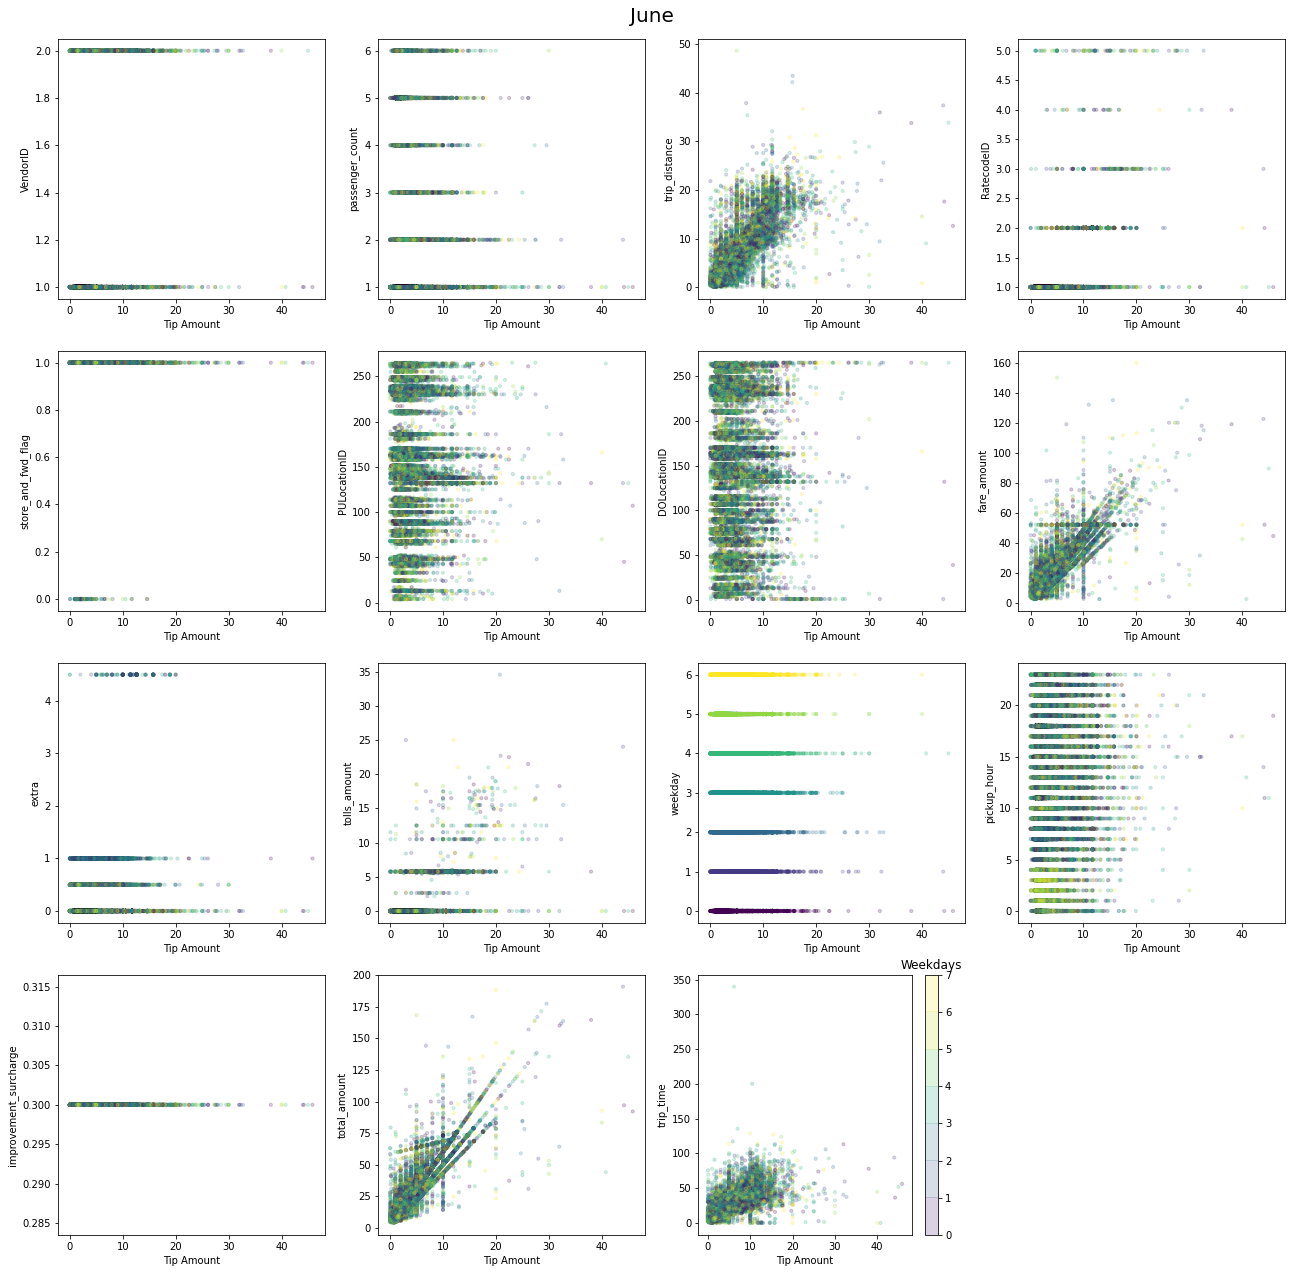

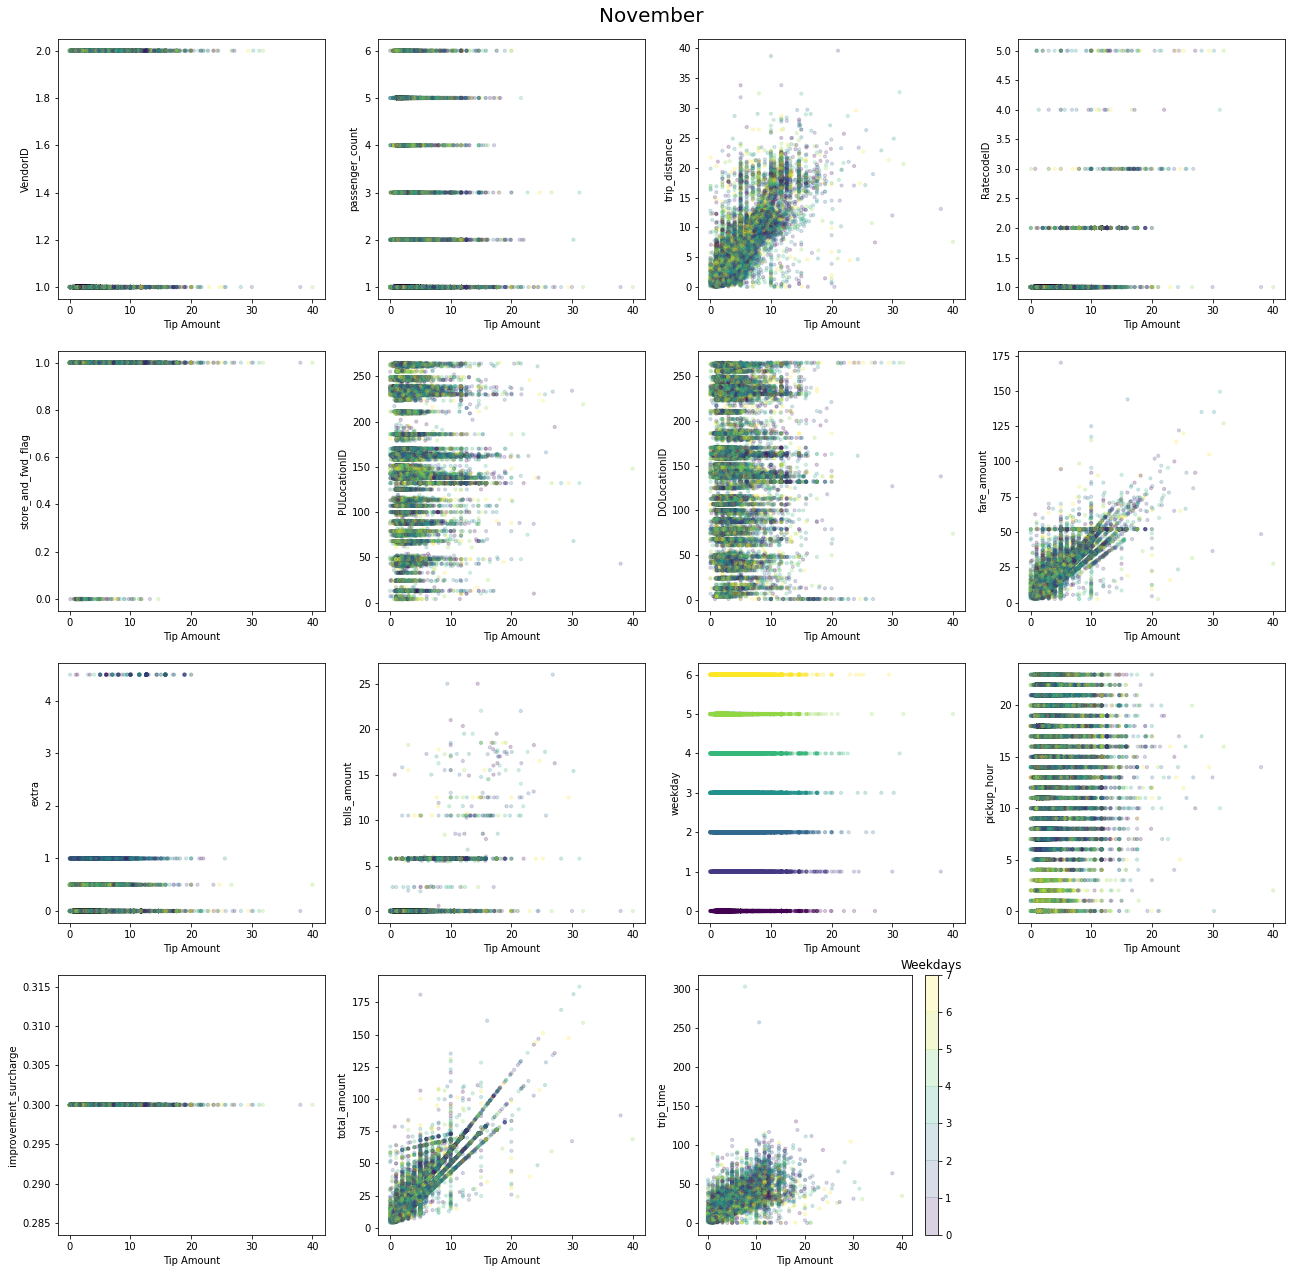

In [125]:
columns_for_scatter = ['VendorID',  'passenger_count', 'trip_distance', 'RatecodeID',
                       'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
                       'fare_amount', 'extra', 'tolls_amount', 'weekday', 'pickup_hour',
                       'improvement_surcharge', 'total_amount', 'trip_time']

month_dic = {'March': 3, 'June': 6, 'November': 11}

for mon in month_dic:
  fig1 = plt.figure(figsize=(22,22))
  index = 0
  for var in columns_for_scatter:

    index += 1
    ax = fig1.add_subplot(4, 4, index)
    sc = plt.scatter(df2['tip_amount'][df2['tpep_pickup_datetime'].dt.month == month_dic[mon]],
                     df2[var][df2['tpep_pickup_datetime'].dt.month == month_dic[mon]],
                     alpha = 0.2, s = 10, c=df2['weekday'][df2['tpep_pickup_datetime'].dt.month == month_dic[mon]])
    plt.xlabel("Tip Amount")
    plt.ylabel(var)
  fig1.suptitle(mon, size=20, y=0.9)
  cbar = plt.colorbar(spacing='proportional', ticks=range(0,8), boundaries=range(0,8)) 
  cbar.ax.set_title('Weekdays')
  plt.show()

Drop **improvement_surcharge** column:



In [126]:
df2.drop(['improvement_surcharge'], axis=1, inplace=True)

The ratecode ID for fare_amount of 52 $ is indeed nr 2, which corresponds to JFK airport.

In [161]:
df2[['fare_amount','RatecodeID']][df2['fare_amount'] == 52].head(10)

,fare_amount,RatecodeID
5590295,52.0,2
13559654,52.0,2
4321935,52.0,2
11407077,52.0,2
3499575,52.0,2
9702169,52.0,2
16772778,52.0,2
11827005,52.0,2
4094399,52.0,2
1174340,52.0,2


To investigate a bit further the relationship between the tip amount and the day of the week & pick-up time, we plot the heatmap for the **total sum of tips (top)** and the **mean tips (bottom)**. 

The top heatmap shows that the largest sum of tips is generated at 21-22h in the middle of the week (Wednesday-Thursday). As expected, less tips are given in total during the late night, surely related to less trips.

The bottom heatmap shows that, on average, the larger tips are given before the sunrise.

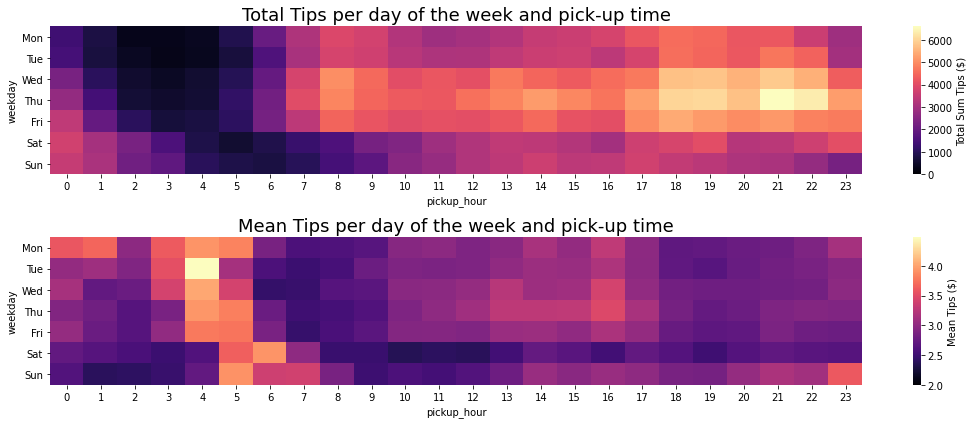

In [210]:
day_name = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(15,6))
ax1 = plt.subplot(2,1,1)
sns.heatmap(data=pd.crosstab(df2.weekday, df2.pickup_hour, values=df2.tip_amount,
                             aggfunc='sum'), vmin=0, cmap='magma', yticklabels = day_name,
                              cbar_kws={'label': 'Total Sum Tips ($)'})
plt.title('Total Tips per day of the week and pick-up time', fontsize = 18)
ax2 = plt.subplot(2,1,2)
sns.heatmap(data=pd.crosstab(df2.weekday, df2.pickup_hour, values=df2.tip_amount,
                             aggfunc='mean'), vmin=2, cmap='magma', yticklabels = day_name,
                              cbar_kws={'label': 'Mean Tips ($)'})
plt.title('Mean Tips per day of the week and pick-up time', fontsize = 18)
plt.tight_layout()
plt.show()

Now we divide the trip duration into 6 bins, seeing that short trips **between 5 and 10 minutes** are the most often repeated.

In [128]:
bins = np.array([0,5,10,15,20,40,500])
df2['trip_duration'] = pd.cut(df2.trip_time,bins,labels=['<5', '5-10', '10-15', '15-20', '20-40', '>40'])

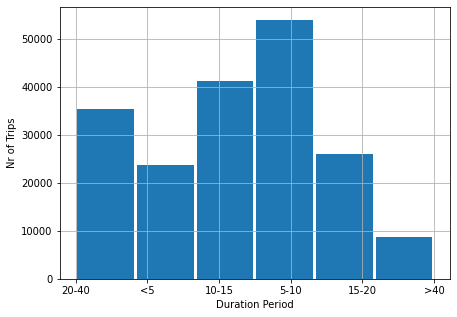

In [130]:
df2['trip_duration'].hist(bins=6, figsize=(7,5), rwidth=0.95)
plt.xlabel("Duration Period")
plt.ylabel("Nr of Trips")
plt.show()

Let's make bins for the total amount, the distance and whether it is weekend or weekday:

In [131]:
bins = np.array([0,5,10,15,25,50,75,100,150,190])
df2['total_amount_bins'] = pd.cut(df2.total_amount,bins,labels=['<5', '5-10', '10-15', '15-25', '25-50', '50-75', '75-100', '100-150', '>150'])

In [132]:
bins = np.array([0,1,3,5,10,15,25,60])
df2['distance_bins'] = pd.cut(df2.trip_distance,bins,labels=['<1', '1-3', '3-5', '5-10', '10-15', '15-25', '>25'])

In [156]:
bins = np.array([-1,4,6])
df2['weekend_or_not'] = pd.cut(df2.weekday,bins,labels=['Weekday', 'Weekend'])

## **Violin Plots dividing into Weekdays/Weekend**

Showing the distribution of the tips according to other variables and colouring according to weekday/weekend criteria in search of interesting patterns. 

* The days of the week, the number of paassengers, the Vendor ID and the pick-up times do not tend to impact the tip amount significantly.

* The RatecodeID shows lower tips for standard rate (1), while the passengers travelling to JFK airport (2) tend to give similar tips of about 12$. The largest tips are for Newark (3) and the other 2 (Negotiated Rate and Group Fare) are very similar.

* There are no extra charges of 4.5\$ during the weekends. But people paying 4.5\$ give 3 times more tips than the others. 

* Tips are higher for longer trips (both in duration and distance).

* For a reason I do not know, for the category 'Store and forward trip' (0), tips are typically higher as for 'Not store and forward trip' (1).

* Finally, for the total amount (bins), there is an exponential growth in the distribution of tips when the total amount is larger, while the distribution also gets more flat (larger extremes).



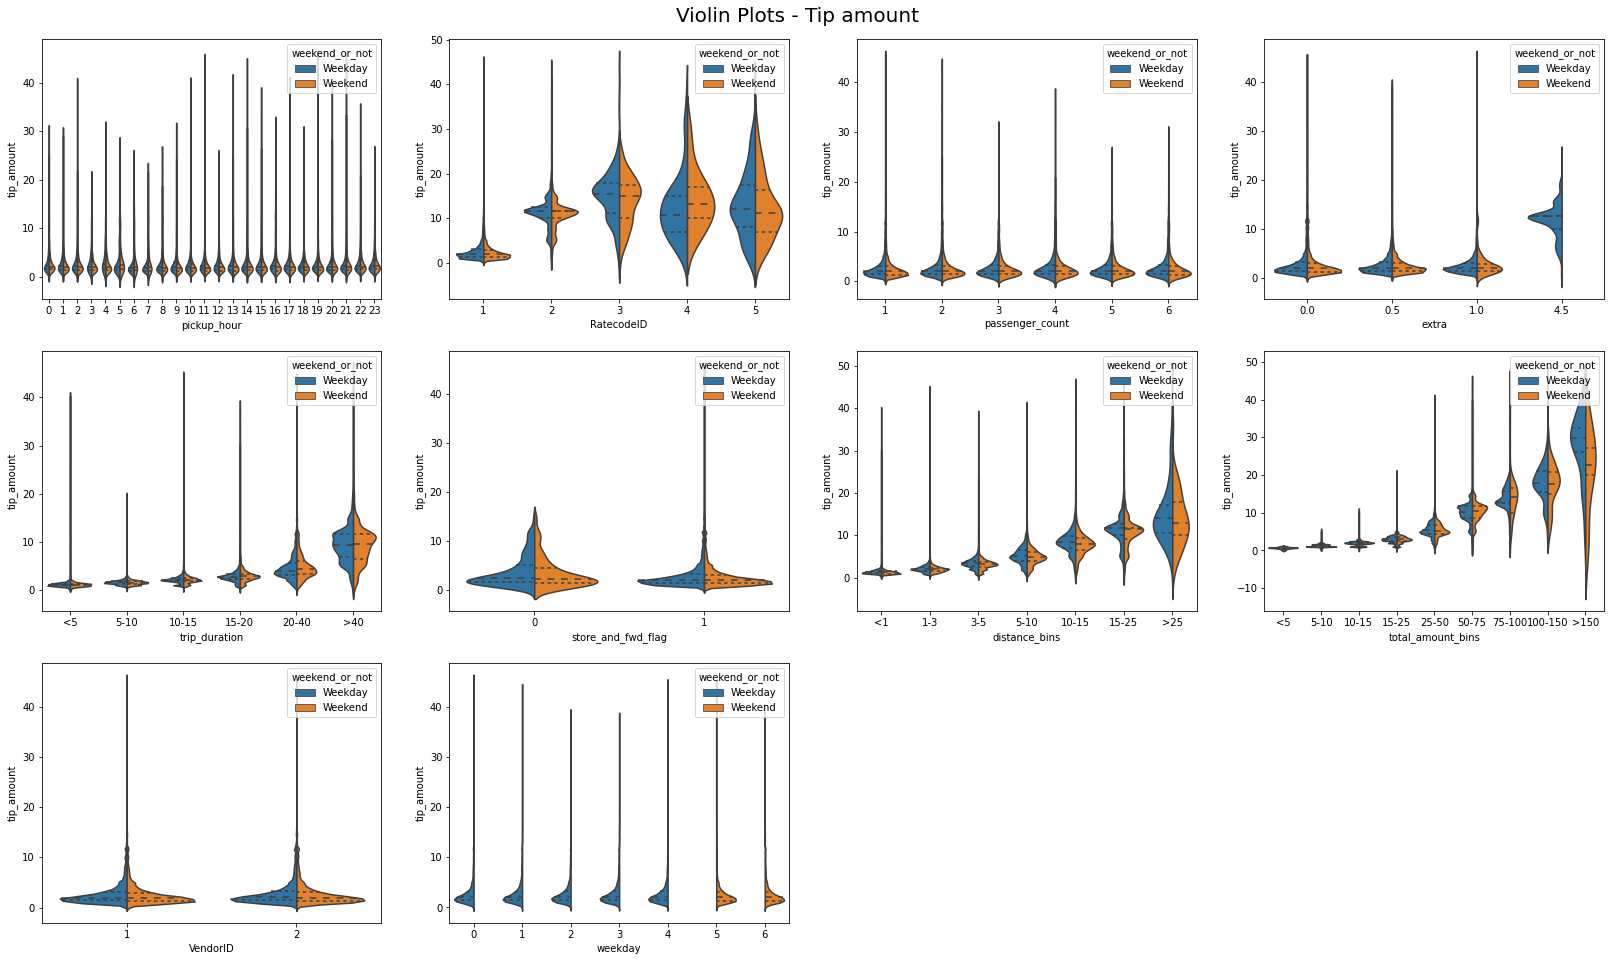

In [158]:
columns_for_violin = ['pickup_hour', 'RatecodeID', 'passenger_count', 'extra', 'trip_duration',
                      'store_and_fwd_flag', 'distance_bins', 'total_amount_bins',
                      'VendorID', 'weekday']
                
fig1 = plt.figure(figsize=(28,22))
index = 0
for var in columns_for_violin:
  index += 1
  ax = fig1.add_subplot(4, 4, index)
  sns.violinplot(x=var, y='tip_amount', hue='weekend_or_not',data=df2,
                 split=True,inner='quartile')

fig1.suptitle('Violin Plots - Tip amount', size=20, y=0.9)
plt.show()

The extra 4.5$ seem to be associated to an extra fare (maybe big luggage?) for some passengers going to the airport during the week days (it does not apply to the weekends as we have seen in the violin plot).

In [172]:
df2['extra'][(df2['extra']==4.5) & (df2['RatecodeID'] == 2) & (df2['weekend_or_not'] == 'Weekday')].value_counts()

4.5    739
Name: extra, dtype: int64

In [174]:
df2['extra'][(df2['extra']!=4.5) & (df2['RatecodeID'] == 2) & (df2['weekend_or_not'] == 'Weekday')].value_counts()

0.0    2398
Name: extra, dtype: int64

We now repeat the correlation heatmap to check that the random subset keeps the same features of the whole dataset, which is indeed the case.

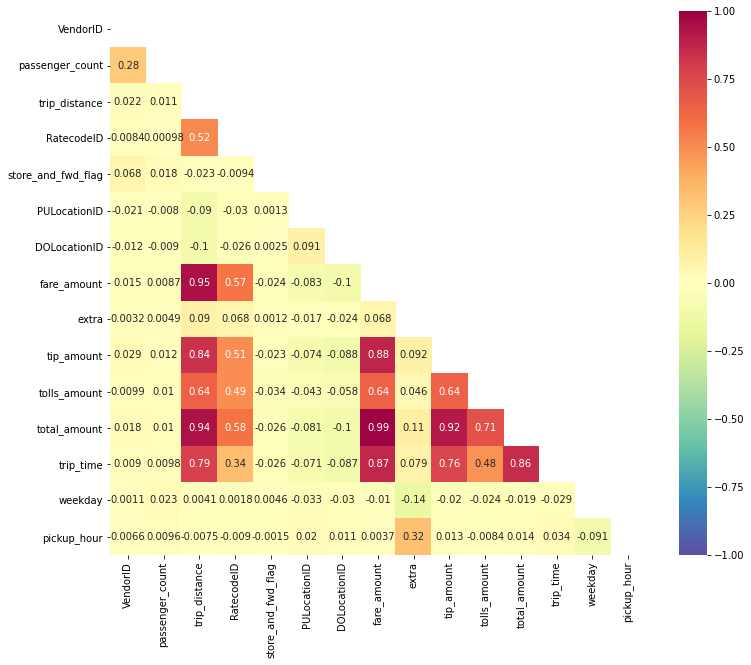

In [268]:
plt.figure(figsize=(12,10))
matrix = np.triu(df2.corr())
sns.heatmap(df2.corr(),cmap='Spectral_r',mask=matrix,annot=True,cbar=True,vmin=-1,vmax=1,center=0)

Finally, we will explore briefly some basic spatial patterns: the total and mean tip amount by location.

In [221]:
geo = gpd.read_file('/content/drive/My Drive/DATA_SCIENCE/Taxi_Test/data/taxi_zones.shp')

In [338]:
mean_by_loc = pd.DataFrame(df2.groupby(['PULocationID'])['tip_amount'].mean().reset_index(name ='mean_tip_per_location'))
mean_shp = geo.merge(mean_by_loc, left_on='LocationID', right_on='PULocationID', how='inner')

In [341]:
sum_by_loc = pd.DataFrame(df2.groupby(['PULocationID'])['tip_amount'].sum().reset_index(name ='total_tip_per_location'))
sum_shp = geo.merge(sum_by_loc, left_on='LocationID', right_on='PULocationID', how='inner')

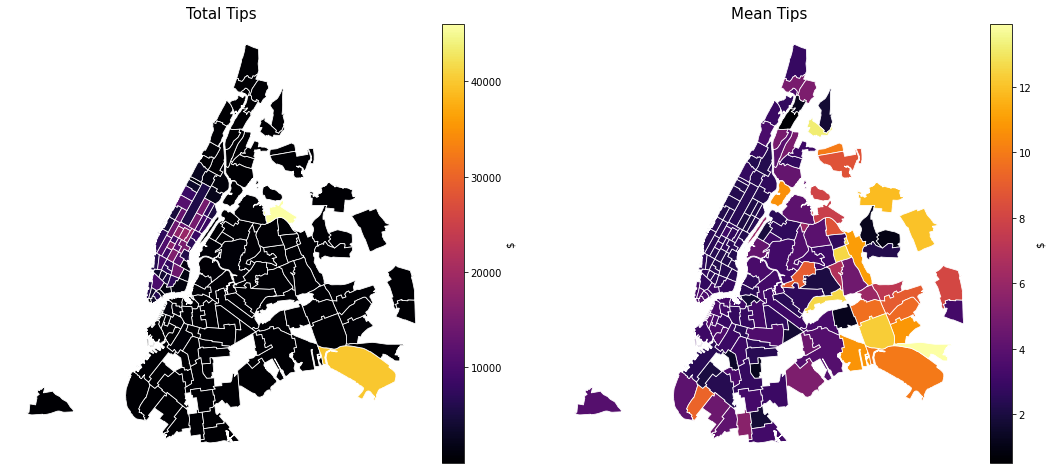

In [344]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)

sum_shp.plot(column='total_tip_per_location', cmap='inferno',
         edgecolor='white', legend=True, legend_kwds={'label': '$'}, linewidth=0.8, ax = ax1, cax=cax1)
ax1.set_title("Total Tips", fontsize=15)
ax1.set_axis_off()

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

mean_shp.plot(column='mean_tip_per_location', cmap='inferno', 
         edgecolor='white', legend=True, legend_kwds={'label': '$'}, linewidth=0.8, ax = ax2, cax = cax2)
ax2.set_title("Mean Tips", fontsize=15)
ax2.set_axis_off()
plt.show()

We can see that in absolute terms, the sum of tips is mostly shared between 3 locations: Manhattan, JFK airport and La Guardia airport.

In average tips, 

In [212]:
df2.to_csv('YellowTaxi_Mar-Jun-Nov2017_subset.csv', index=False)

We are ready to build the predictive model. Continue on Part 3: **Model_Building**.


---

